# Boston Dataset Analysis

In [41]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import ensemble

# Calculate VIF and drop colinear variables
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X.iloc[:,variables].values, ix) for ix in range(X.iloc[:,variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:,variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:,variables]

def run_estimators(estimators, X_train, y_train, X_test, y_test, scoring, cv=5, verbose=False):

    scores = []
    
    for clf in estimators:
        print("Running {0}...".format(clf.__class__.__name__))
        start_time = timeit.default_timer()
        clf.fit(X_train, y_train)
        elapsed = timeit.default_timer() - start_time
        print('Time Elapsed: ' + str(elapsed))
                
        test_scores = cross_val_score(clf, X_test, y_test, scoring=scoring, cv=cv)
        mean_test_cv_score = np.mean(test_scores)
        std_def_test_cv_score = np.std(test_scores)
        
        if verbose:
            train_scores = cross_val_score(clf, X_train, y_train, scoring=scoring, cv=cv)
            print("Mean Train CV Score: {0}".format(np.mean(train_scores)))
            print("Std. Dev. Train CV Score: {0}".format(np.std(train_scores)))
            print("Mean Test CV Score: {0}".format(mean_test_cv_score))
            print("Std. Dev. Test CV Score: {0}".format(std_dev_test_cv_score))  
        
        scores.append((clf.__class__.__name__ + " " + str(clf.get_params()), mean_test_cv_score, std_def_test_cv_score))
        
    return sorted(scores, key=lambda x: x[1], reverse=True)
        
        
def get_oof(clf, x_train, y_train, x_test, n_folds=5, random_state=16):
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    
    kf = KFold(ntrain, n_folds=n_folds, random_state=random_state)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((n_folds, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return pd.DataFrame(oof_train.reshape(-1, 1)), pd.DataFrame(oof_test.reshape(-1, 1))

def stack(estimators, X_train, y_train, X_test):
    stacked_X_train = pd.DataFrame()
    stacked_X_test = pd.DataFrame()
    
    cols = []
    
    for est in estimators:
        cols.append(est.__class__.__name__)
        est_oof_train, est_oof_test = get_oof(est, X_train, y_train, X_test)
        
        stacked_X_train = pd.concat([stacked_X_train, est_oof_train], axis=1)
        stacked_X_test = pd.concat([stacked_X_test, est_oof_test], axis=1)
        
    stacked_X_train.columns = cols
    stacked_X_test.columns = cols
    
    return stacked_X_train, stacked_X_test
        
seed = 16

# Load Boston Dataset
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

In [2]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [3]:
# Missing Values Check
df.isnull().any()

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
target     False
dtype: bool

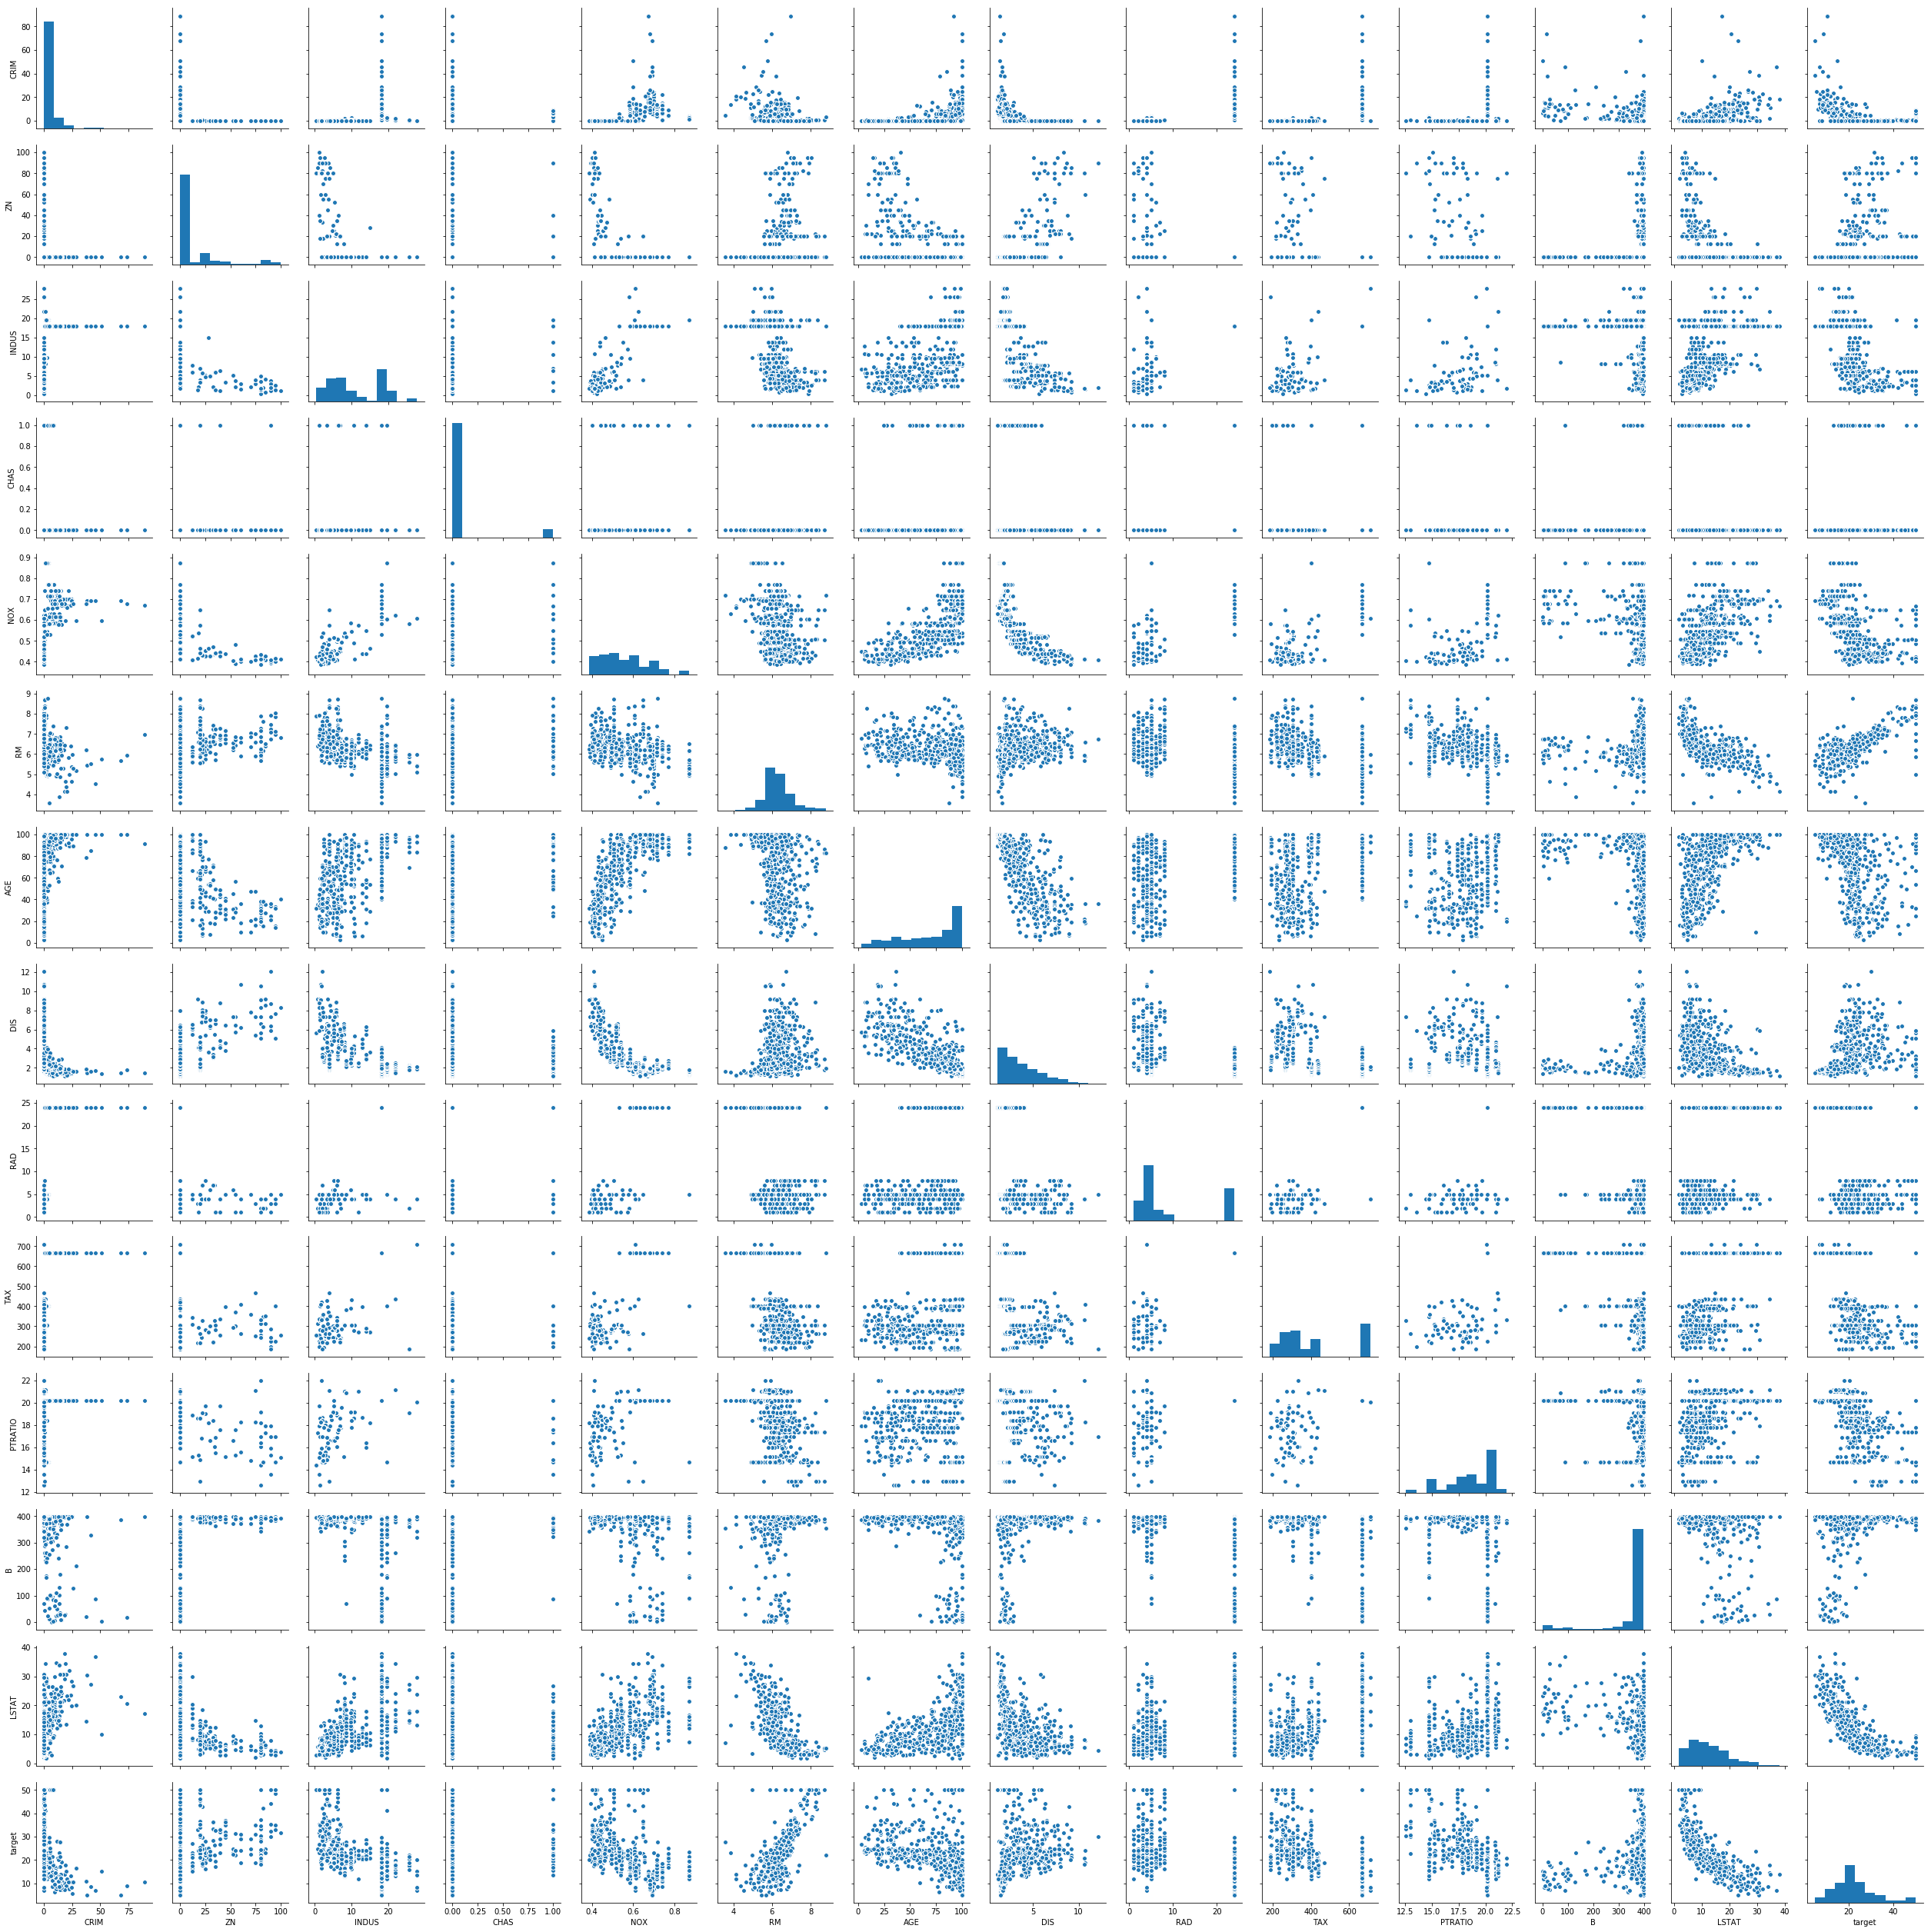

In [4]:
# Pair Plot
sns.pairplot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9912d09588>,
      dtype=object)

<Figure size 1008x720 with 0 Axes>

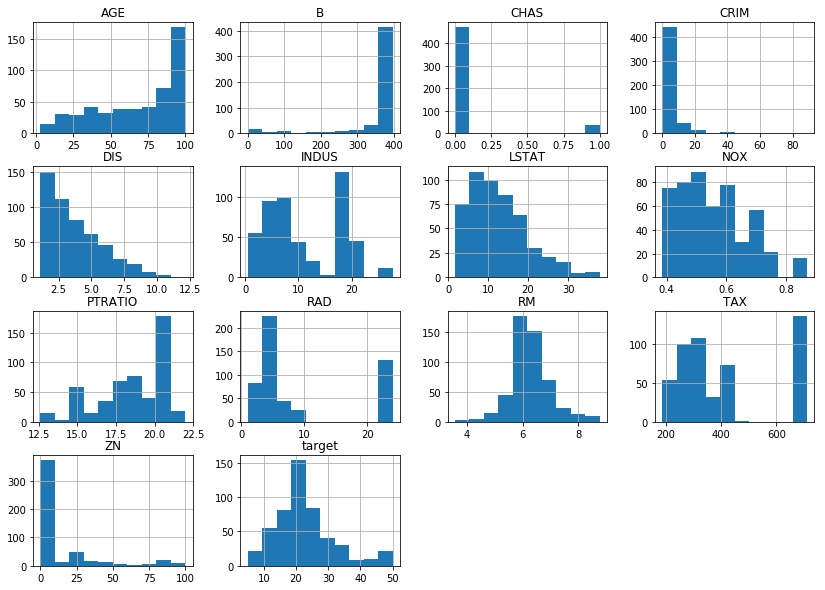

In [5]:
df.hist(figsize=(14,10))

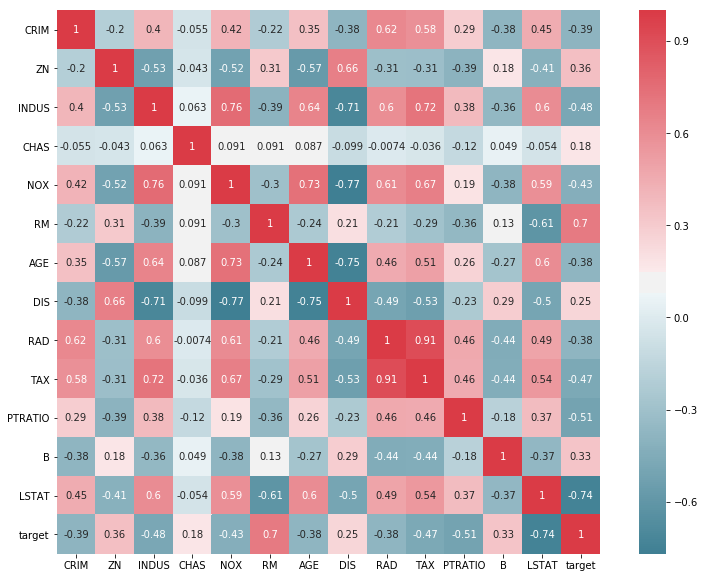

In [6]:
# Correlation Map

f, ax = plt.subplots(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [7]:
# Detect Multicollinearity
# range from 0 (Perfect Collinearity) to 1 (No Collinearity)

# Compare the determinant
print(np.linalg.det(corr)) 

3.482819589959191e-05


## Preprocess and Model Training

In [118]:
y = df['target']
X = df.drop(['target'], axis=1)

In [119]:
# Standardize
# Standardization is required for L1 and L2 Regularization, SVMs, and PCA (More or less any algorithm based on distance)
scaler = StandardScaler()
col_names = X.columns
X = pd.DataFrame(scaler.fit_transform(X), columns=col_names)

# Drop colinear Variables
X = calculate_vif_(X)
# Compare the determinant
print(np.linalg.det(X.corr())) 

X.head()

dropping 'TAX' at index: 9
Remaining variables:
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
0.001209553581536344


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-1.459000,0.441052,-1.075562
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.303094,0.441052,-0.492439
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.303094,0.396427,-1.208727
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,0.113032,0.416163,-1.361517
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,0.113032,0.441052,-1.026501


In [120]:
# Test, Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

Start from simple to complex

Linear Models -> Support Vectors -> Trees -> Ensembles, Boosting, Bagging, Etc. -> Stacked Models

In [122]:
# Regression
clfs =[
    # Linear Models
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.BayesianRidge(),
    linear_model.Lasso(),
    linear_model.LassoLars(),
    linear_model.Lars(),
    linear_model.ElasticNet(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(max_iter=1000, tol=1e-3), # 0.21 defaults
    linear_model.RANSACRegressor(),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3),  # 0.21 defaults
    linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3),  # 0.21 defaults
    # K-Neighbors
    neighbors.KNeighborsRegressor(n_neighbors = 1),
    neighbors.KNeighborsRegressor(n_neighbors = 2),
    neighbors.KNeighborsRegressor(n_neighbors = 4),
    neighbors.KNeighborsRegressor(n_neighbors = 8),
    neighbors.KNeighborsRegressor(n_neighbors = 16),
    neighbors.KNeighborsRegressor(n_neighbors = 32),
    neighbors.KNeighborsRegressor(n_neighbors = 64),
    # Support Vector Machines
    svm.LinearSVR(), #liblinear
    svm.NuSVR(),
    svm.SVR(kernel="linear"), #libsvm
    svm.SVR(kernel="sigmoid"),
    svm.SVR(kernel="rbf"),
    # Tree (CART)
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    # Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.IsolationForest(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor()
    #TODO State of the art models - e.g. XGBoost
]

scores = run_estimators(clfs, X_train, y_train, X_test, y_test, scoring="neg_mean_squared_error")

print("\nBest Scores:")
for s in scores:
    print("{0}\n{1} (+/- {2})".format(s[0], s[1], s[2]))

Running LinearRegression...
Time Elapsed: 0.004117655000300147
Running Ridge...
Time Elapsed: 0.001271556997380685
Running BayesianRidge...
Time Elapsed: 0.0016234240029007196
Running Lasso...
Time Elapsed: 0.001010207000945229
Running LassoLars...
Time Elapsed: 0.001051967999956105
Running Lars...
Time Elapsed: 0.0031392520031658933
Running ElasticNet...
Time Elapsed: 0.001060380003764294
Running ARDRegression...
Time Elapsed: 1.6305177510002977
Running PassiveAggressiveRegressor...
Time Elapsed: 0.0008463279955321923
Running RANSACRegressor...
Time Elapsed: 0.08784501499758335
Running SGDRegressor...
Time Elapsed: 0.0017599409984541126
Running TheilSenRegressor...
Time Elapsed: 1.2331176289953873
Running KNeighborsRegressor...
Time Elapsed: 0.0005160910004633479
Running KNeighborsRegressor...
Time Elapsed: 0.0007117069981177337
Running KNeighborsRegressor...
Time Elapsed: 0.000887404996319674
Running KNeighborsRegressor...
Time Elapsed: 0.0007463889996870421
Running KNeighborsRegress

### Tune Best Models

In [ ]:
lr = linear_model.LinearRegression()

# Nothing to tune in Linear Regression

In [ ]:
svr_linear = svm.SVR(kernel="linear")

param_grid = [{'C': [0.001, 0.01, 1],}]
clf = GridSearchCV(svr_linear, param_grid,cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Best parameters set found on train set:")
print()
print(clf.best_params_)
print()
print("Grid scores on train set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [ ]:
et = ensemble.ExtraTreesRegressor()

param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
clf = GridSearchCV(et, param_grid,cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Best parameters set found on train set:")
print()
print(clf.best_params_)
print()
print("Grid scores on train set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [138]:
clfs = [
    linear_model.LinearRegression(),
    neighbors.KNeighborsRegressor(n_neighbors = 4),
    neighbors.KNeighborsRegressor(n_neighbors = 8),
    ensemble.ExtraTreesRegressor(max_depth=25, min_samples_leaf=1, n_estimators=27),
    ensemble.GradientBoostingRegressor(),
    svm.SVR(kernel="linear")
]

X_train_2, X_test_2 = stack(clfs, X_train, y_train, X_test)

stacker = linear_model.ARDRegression()
stacker.fit(X_train_2, y_train)
scores = cross_val_score(stacker, X_test_2, y_test, scoring='neg_mean_squared_error', cv=5)

print("Mean Neg MSE: {0}, Std. Dev. Neg MSE: {1}".format(np.mean(scores), np.std(scores)))

Mean Neg MSE: -8.495521741399447, Std. Dev. Neg MSE: 1.9962727482986666


In [131]:
X_train_2.head()

,LinearRegression,KNeighborsRegressor,KNeighborsRegressor,ExtraTreesRegressor,GradientBoostingRegressor,SVR
0,40.222827,39.350,38.7625,43.900000,46.109754,39.042846
1,23.561561,19.900,19.9625,19.922222,20.215412,21.327369
2,18.204149,15.100,13.3375,12.900000,13.595226,15.934937
3,31.474056,34.075,30.1000,30.640741,30.477106,30.355145
4,20.780532,21.075,21.8875,21.337037,20.817782,20.748090


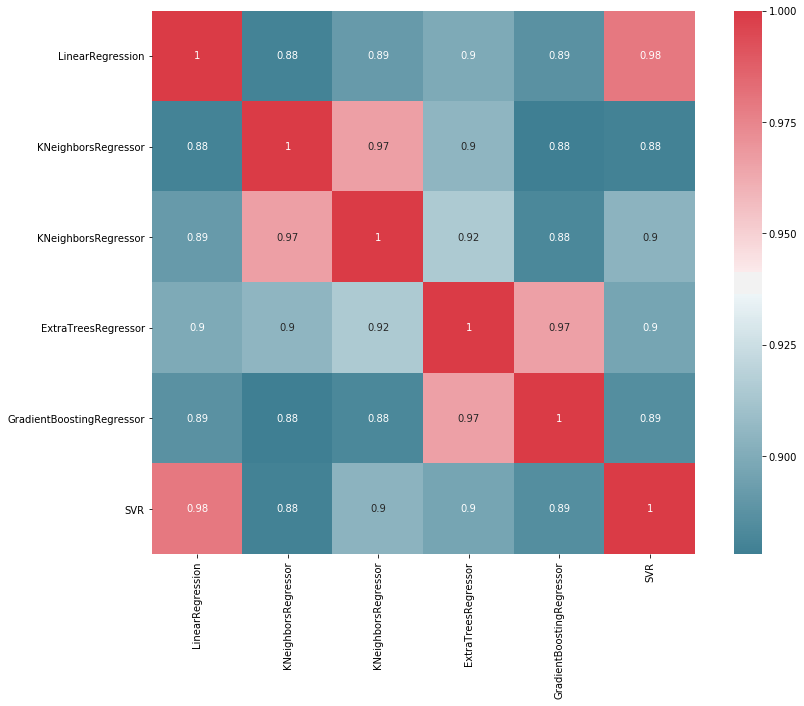

In [136]:
f, ax = plt.subplots(figsize=(14, 10))
corr = X_train_2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

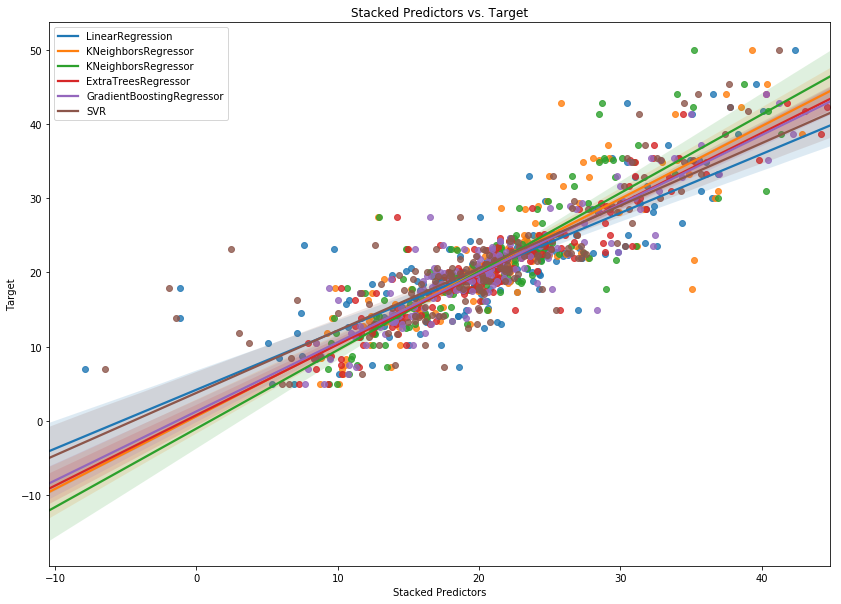

In [135]:
plt.figure(figsize=(14,10))

sns.regplot(x=X_test_2['LinearRegression'], y=y_test)
sns.regplot(x=X_test_2['KNeighborsRegressor'].iloc[:,0], y=y_test)
sns.regplot(x=X_test_2['KNeighborsRegressor'].iloc[:,1], y=y_test)
sns.regplot(x=X_test_2['ExtraTreesRegressor'], y=y_test)
sns.regplot(x=X_test_2['GradientBoostingRegressor'], y=y_test)
ax = sns.regplot(x=X_test_2['SVR'], y=y_test)

ax.set(xlabel='Stacked Predictors', ylabel='Target', title='Stacked Predictors vs. Target')
ax.legend(X_test_2.columns)
plt.show()